# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from collections import defaultdict
import numpy as np
import seaborn as sns
from pyteomics.parser import cleave

# Plotting parameters

In [12]:

# Define the settings for the plots
rc = {'figure.figsize':(15,10),
      'axes.facecolor':'white',
      'figure.facecolor':'white',
      'axes.grid' : False,
      'font.size' : 20}

# Define Functions

In [6]:
# Define a function to digest the sequences in the database
def digest(protein_sequence, enzyme):
    '''
    digests the protein sequences with the enzyme of choice
    possible choices for enzyme are trypsin, chymotrypsin, and aspnlysc
    '''
    if enzyme == 'trypsin':
        seq_cut = cleave(protein_sequence, rule='[KR]', min_length=7, missed_cleavages=2)
        plist=set() #to prevent duplicates

    elif enzyme == 'chymotrypsin':
        seq_cut = cleave(protein_sequence, rule='[FLWY]', min_length=7, missed_cleavages=2)
        plist=set() #to prevent duplicates

    elif enzyme == 'aspnlysc':
        seq_cut = cleave(protein_sequence, rule='[DK]', min_length=7, missed_cleavages=2)
        plist=set() #to prevent duplicates

    else:
        print('enzyme must be trypsin, chymotrypsin or aspnlysc')

    for peptide in seq_cut:
        if peptide in plist or len(peptide) < 7 or len(peptide) > 50:
            continue
        plist.add(peptide)
    return(plist)

def refine_source(sources):
    if len(set(sources))==1:
        return(sources[0])
    return('Multi-mapping')

def absolute_value(val):
    a  = np.round(val/100.*db.source.value_counts().sum())
    return int(a)

# Load the database

In [7]:
# Load the PacBio-GENCODE database as a dataframe
data = defaultdict(list)
with open('../data/proteomics/hnr_50_hybrid.fasta') as fp:
  for record in SeqIO.parse(fp,"fasta"):
    ident = record.id
    sequence = str(record.seq)
    data['id'].append(ident)
    data['sequence'].append(sequence)

db = pd.DataFrame.from_dict(data)
db.head()

db['peptides_chymotrypsin']=db.apply(lambda x: digest(x['sequence'], 'chymotrypsin'), axis=1)
db['peptides_aspnlysc']=db.apply(lambda x: digest(x['sequence'], 'aspnlysc'), axis=1)

db['source']=db['id'].apply(lambda x: x.split('|',1)[0])
db['source']=db['source'].str.replace('gc','Gencode')
db['source']=db['source'].str.replace('pb','Novel')


# A. Digestion with Chymotrypsin

Text(-0.7365782312495951, 0.816977667533953, 'GENCODE')
Text(-0.4017699443179609, 0.445624182291247, '76014')
Text(0.6983982598816256, -0.8498469689269461, 'multi-mapping')
Text(0.38094450538997754, -0.46355289214197054, '26101')
Text(1.0988463133683926, -0.05036645308826389, 'novel')
Text(0.5993707163827595, -0.027472610775416666, '1511')


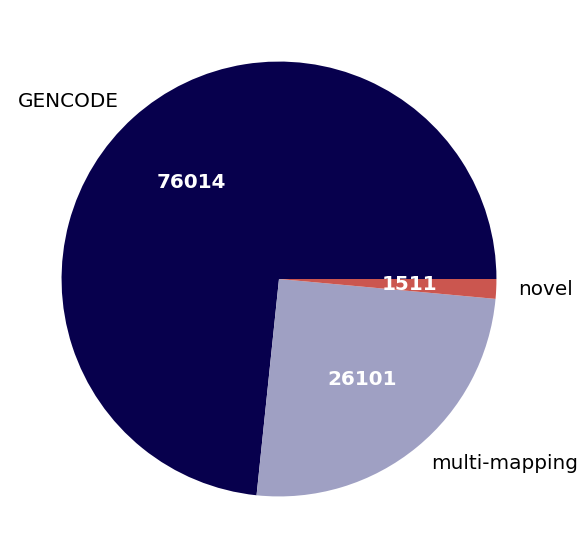

In [15]:
pepinfo_chymotrypsin=db[['source','peptides_chymotrypsin']].explode('peptides_chymotrypsin').groupby('peptides_chymotrypsin').agg(list)
pepinfo_chymotrypsin['source']=pepinfo_chymotrypsin.source.apply(refine_source)

plt.rcParams.update(rc)
ax = pepinfo_chymotrypsin.source.value_counts().plot.pie(autopct=absolute_value, colors = ['#07004D', '#9FA0C3','#cb564f'], labels = ['GENCODE', 'multi-mapping', 'novel'])
for text, color, weight in zip(ax.texts, ['black', 'white', 'black', 'white', 'black', 'white'], ['normal', 'bold', 'normal', 'bold', 'normal', 'bold']):
    print(text)
    text.set_color(color)
    text.set_weight(weight)
ax.axes.get_yaxis().set_visible(False)
plt.savefig('plots/peptides_chymotrypsin.svg', dpi = 300,  bbox_inches='tight')
plt.show()

# B. Digestion with AspN and LysC

Text(-0.712238491171614, 0.8382817734470809, 'GENCODE')
Text(-0.38849372245724395, 0.4572446036984077, '75044')
Text(0.6775567116645989, -0.8665546159811601, 'multi-mapping')
Text(0.3695763881806902, -0.47266615417154184, '27240')
Text(1.0990899206548235, -0.04473640927671815, 'novel')
Text(0.5995035930844491, -0.024401677787300808, '1342')


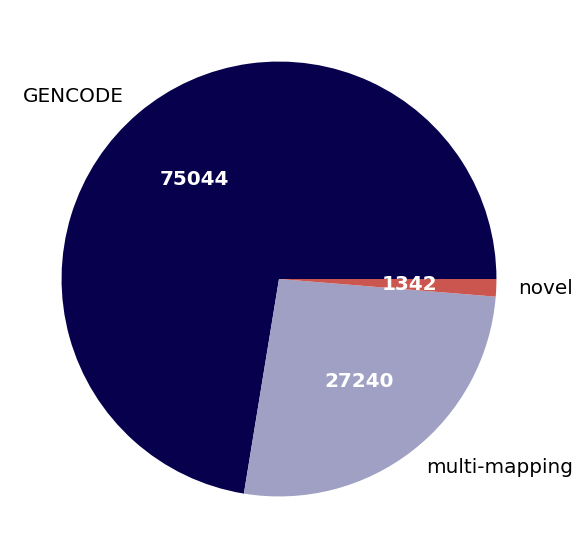

In [16]:
pepinfo_aspnlysc=db[['source','peptides_aspnlysc']].explode('peptides_aspnlysc').groupby('peptides_aspnlysc').agg(list)
pepinfo_aspnlysc['source']=pepinfo_aspnlysc.source.apply(refine_source)

plt.rcParams.update(rc)
ax = pepinfo_aspnlysc.source.value_counts().plot.pie(autopct=absolute_value, colors = ['#07004D', '#9FA0C3','#cb564f'], labels = ['GENCODE', 'multi-mapping', 'novel'])
for text, color, weight in zip(ax.texts, ['black', 'white', 'black', 'white', 'black', 'white'], ['normal', 'bold', 'normal', 'bold', 'normal', 'bold']):
    print(text)
    text.set_color(color)
    text.set_weight(weight)
ax.axes.get_yaxis().set_visible(False)
plt.savefig('plots/peptides_aspn_lysc.svg', dpi = 300,  bbox_inches='tight')
plt.show()